# Fixed Source Transmutation Problem

Based on 1D model of HYPR system prototype

In [1]:
import openmc
import openmc.deplete
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
# Define planar source geometry
xmin = -5
xmax = 5
ymin = -5
ymax = 5
zpos = 0.01

x_dist = openmc.stats.Uniform(xmin,xmax)
y_dist = openmc.stats.Uniform(ymin,ymax)
z_dist = openmc.stats.Discrete([zpos],[1.0])

plan_dist = openmc.stats.CartesianIndependent(x_dist,y_dist,z_dist)
angle_dist = openmc.stats.Monodirectional((0.0,0.0,1.0))

In [3]:
# define settings
settings = openmc.Settings() # create openmc settings object
energy = openmc.stats.Watt() # create energy spectrum of particles
settings.source = openmc.Source(space=plan_dist, energy=energy, angle=angle_dist)
settings.run_mode = 'fixed source'
settings.batches = 100
settings.particles = 50000
settings.generations_per_batch = 1

settings.export_to_xml()

In [4]:
# define materials

water = openmc.Material(name='water')
water.set_density('g/cc',0.989) # density of water at 320K (steady state operating temp of TRIGA)
water.add_element('H',2.0)
water.add_element('O',1.0)
water.add_s_alpha_beta('c_H_in_H2O')

pipe = openmc.Material(name = 'steel') # 304L Stainless steel from PNNL material Compendium
pipe.set_density('g/cc', 8.0)
pipe.add_element('C',0.000687)
pipe.add_element('Si',0.009793)
pipe.add_element('P',0.000408)
pipe.add_element('S',0.000257)
pipe.add_element('Cr',0.201015)
pipe.add_element('Mn',0.010013)
pipe.add_element('Fe',0.684101)
pipe.add_element('Ni',0.093725)


target = openmc.Material(name='target')
target.set_density('g/cc', 0.432)
target.add_nuclide('Np237', 1.0)
target.add_element('H', 1.0)
target.add_element('N', 1.0)
target.add_element('O', 3.0)

# add trace amount of Np238 and Pu238 so depletion works...
target.add_nuclide('Np238',1e-8)
target.add_nuclide('Pu238',1e-8)

target.depletable = True



In [5]:
# create geometry

length = 50. # cm
width = 10.
height = 10.
box = openmc.model.RectangularParallelepiped(-width/2., width/2.,
                                             -height/2., height/2.0,
                                             0., length, boundary_type='vacuum')  

r1 = 35
r2 = 35.23
r3 = 36.23
r4 = 40.23
r5 = 41.23

wwall = openmc.ZPlane(z0 = r1) # wall for water gap between rx and pipe
piwall1 = openmc.ZPlane(z0 = r2) # plane at inner pipe wall
piwall2 = openmc.ZPlane(z0 = r3) 
powall1 = openmc.ZPlane(z0 = r4) 
powall2 = openmc.ZPlane(z0 = r5) 

c1 = openmc.Cell()
c1.region = -box & -wwall
c1.fill = None

c2 = openmc.Cell()
c2.region = -box & +wwall & -piwall1
c2.fill = water

c3 = openmc.Cell()
c3.region = -box & +piwall1 & -piwall2
c3.fill = pipe

c4 = openmc.Cell()
c4.region = -box & +piwall2 & -powall1
c4.fill = target

c5 = openmc.Cell()
c5.region = -box & +powall1 & -powall2
c5.fill = pipe

c6 = openmc.Cell()
c6.region = -box & +powall2
c6.fill = water

root_univ = openmc.Universe()
root_univ.add_cells([c1,c2,c3,c4,c5,c6])

geometry = openmc.Geometry()
geometry.root_universe = root_univ
geometry.export_to_xml()


target.volume = width*height*(r4 - r3); # compute volume of target material for depletion.

materials = openmc.Materials([water, pipe, target])
materials.export_to_xml()

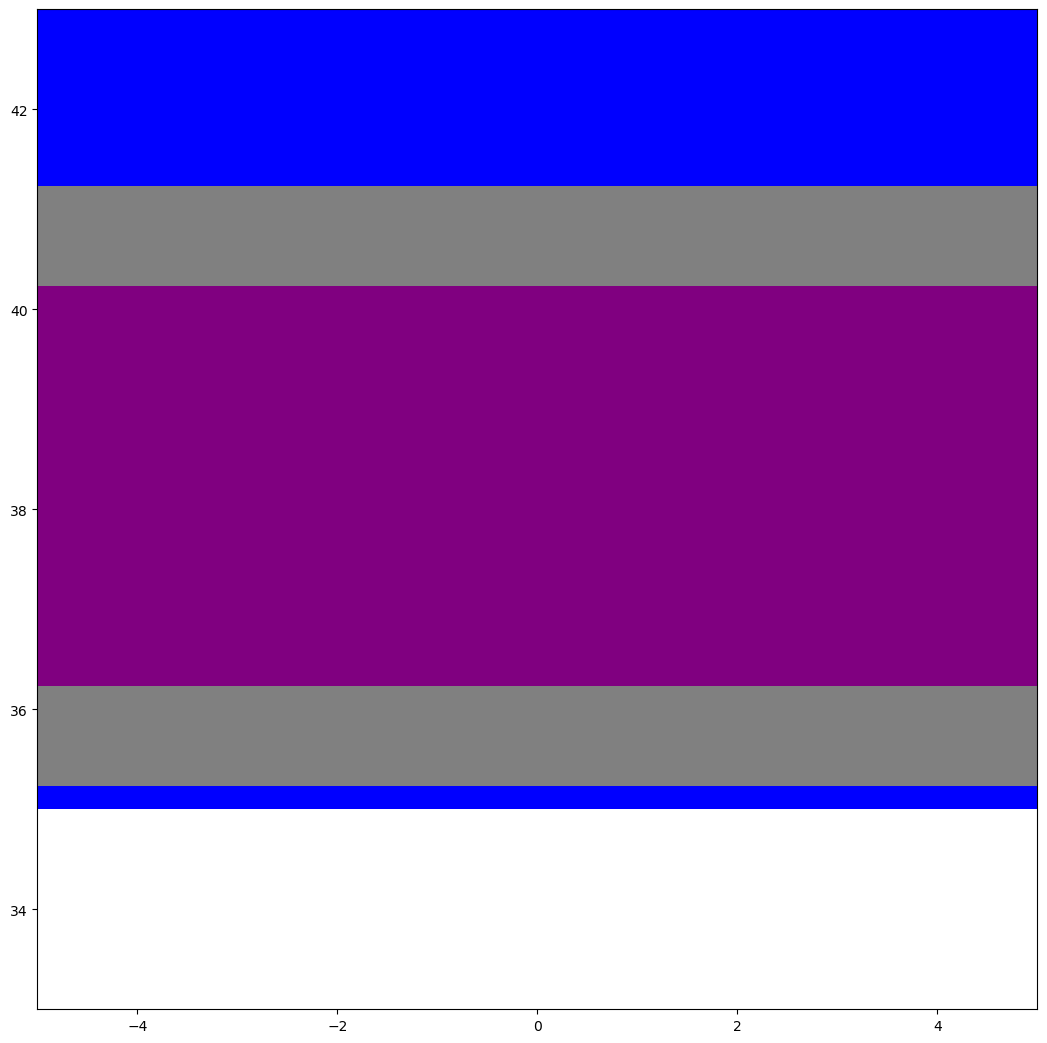

In [6]:
# plot root universe

colors = {}
colors[water]='blue'
colors[pipe]='gray'
colors[target]='purple'
root_univ.plot(origin=(0,0,38),width=(width,10),
               pixels=(1000,1000),color_by='material',
               basis='yz',colors=colors)

Add some tallies.

In [7]:
# create tallies

cell_filter = openmc.CellFilter(c4); # measure in the target material cell


# energy bins
N = 1001;
energy_bins = np.logspace(-3,7,num=N);
energy_filter = openmc.EnergyFilter(values=energy_bins);

# establish a flux tally for the target
flux_target = openmc.Tally(name='flux in target');
flux_target.scores = ['flux'];
flux_target.filters = [cell_filter,energy_filter];

# create a tally to estimate rate of conversion of Np-237 to Np-238
np237_capture_t = openmc.Tally(name='Np237_total_capture');
np237_capture_t.scores = ['(n,gamma)'];
np237_capture_t.nuclides=['Np237'];
efilter_values = [0.0, 1.0, 3.0e4, 14.0e6]; #OpenMC energy units are in eV
efilter_capture = openmc.EnergyFilter(values=efilter_values);
np237_capture_t.filters = [cell_filter,efilter_capture]

# tally fission in Np238
np238_fission_t = openmc.Tally(name='Np238_fiss')
np238_fission_t.scores = ['fission']
np238_fission_t.nuclides = ['Np238']
np238_fission_t.filters = [cell_filter,efilter_capture]

# tally (n,2n) in Np237
np237_n2n_t = openmc.Tally(name='Np237_n2n')
np237_n2n_t.scores = ['(n,2n)']
np237_n2n_t.nuclides = ['Np237']
np237_n2n_t.filters = [cell_filter]


# tally fission in Pu-238
pu238_fission_t = openmc.Tally(name='Pu238_fiss')
pu238_fission_t.scores = ['fission']
pu238_fission_t.nuclides = ['Pu238']
pu238_fission_t.filters = [cell_filter]

# tally (n,gamma) in Pu-238
pu238_capture_t = openmc.Tally(name='Pu238_capture')
pu238_capture_t.scores = ['(n,gamma)']
pu238_capture_t.nuclides = ['Pu238']
pu238_capture_t.filters = [cell_filter]

tallies = openmc.Tallies([ flux_target, np237_capture_t, np237_n2n_t,
                         np238_fission_t, pu238_fission_t, pu238_capture_t]);
#tallies = openmc.Tallies([ flux_target, np237_capture_t, np237_n2n_t]);
tallies.export_to_xml()

In [8]:
model = openmc.model.Model(geometry,materials,settings,tallies)
operator = openmc.deplete.CoupledOperator(model,chain_file="chain_endfb71_pwr.xml",
                                         normalization_mode='source-rate');

# Assume a flux of 1e14 n/cm^2-s
avg_flux = 1.0e14; # n/cm^2-s
source_rate = height*width*avg_flux; # n/s
days = 24*3600;
time_steps = [0.25*days, 0.25*days, 0.25*days, 0.25*days, 0.5*days, 0.5*days,
              1.0*days, 1.0*days, 1.0*days, 1.0*days, 4.0*days, 4.0*days, 
              4.0*days, 4.0*days,4.0*days, 4*days, 4*days, 4*days,4*days,
             30*days, 30*days];

cecm = openmc.deplete.PredictorIntegrator(operator,time_steps,
                                    source_rates=source_rate);


repeat_depletion = False;

if(repeat_depletion):
    cecm.integrate()

In [9]:
results = openmc.deplete.Results('./depletion_results.h5')

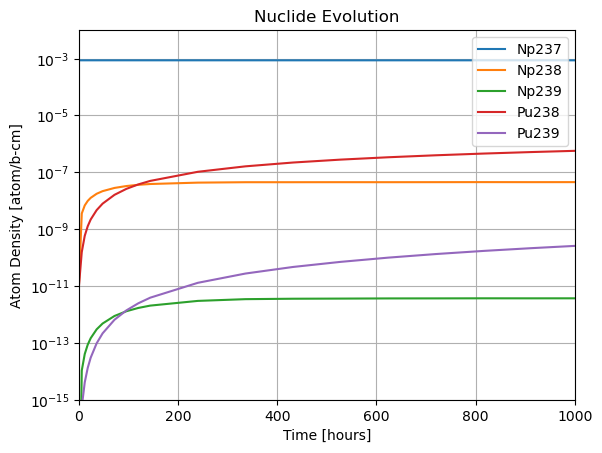

In [10]:
# check the materials.xml file to get the material number for the target
time, np237 = results.get_atoms("3","Np237",nuc_units="atom/b-cm",
                               time_units="h")
time, np238 = results.get_atoms("3","Np238",nuc_units="atom/b-cm",
                               time_units="h")
time, np239 = results.get_atoms("3","Np239",nuc_units="atom/b-cm",
                               time_units="h")
time, pu238 = results.get_atoms("3","Pu238",nuc_units="atom/b-cm",
                                time_units="h")
time, pu239 = results.get_atoms("3","Pu239",nuc_units="atom/b-cm",
                               time_units="h")

time, pu240 = results.get_atoms("3","Pu240",nuc_units="atom/b-cm",
                                time_units="h")
time, pu241 = results.get_atoms("3","Pu241",nuc_units="atom/b-cm",
                               time_units="h")
time, pu242 = results.get_atoms("3","Pu242",nuc_units="atom/b-cm",
                               time_units="h")


plt.semilogy(time,np237,label="Np237")
plt.semilogy(time,np238,label="Np238")
plt.semilogy(time,np239,label="Np239")
plt.semilogy(time,pu238,label="Pu238")
plt.semilogy(time,pu239,label="Pu239")
plt.title("Nuclide Evolution")
plt.xlabel("Time [hours]")
plt.ylabel("Atom Density [atom/b-cm]")
plt.grid()
plt.axis([0,1000,1e-15,1e-2])
plt.legend()

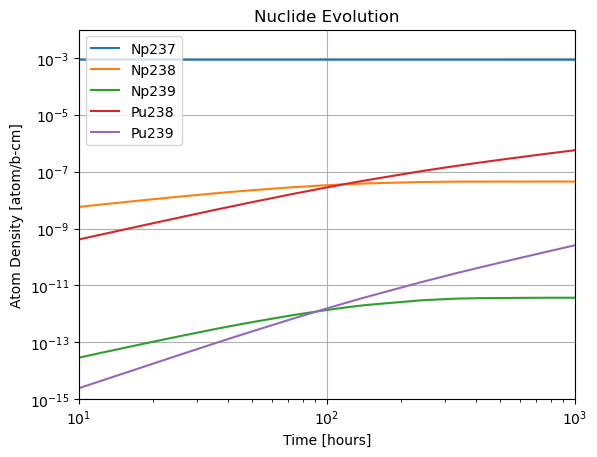

In [11]:
# repeat with loglog plot.

plt.loglog(time,np237,label="Np237")
plt.loglog(time,np238,label="Np238")
plt.loglog(time,np239,label="Np239")
plt.loglog(time,pu238,label="Pu238")
plt.loglog(time,pu239,label="Pu239")
plt.title("Nuclide Evolution")
plt.xlabel("Time [hours]")
plt.ylabel("Atom Density [atom/b-cm]")
plt.grid()
plt.axis([10,1000,1e-15,1e-2])
plt.legend()

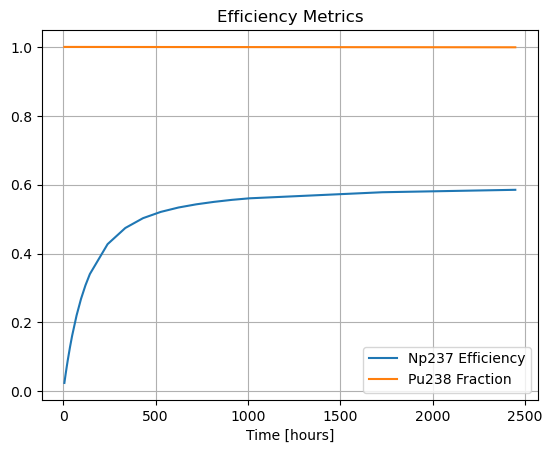

In [12]:
# plot cumulative increase of Pu-238 / cumulative use of Np-237 (metric1)
# and ratio of Pu-238 / all Pu (metric2)

change_np237 = np237[0] - np237[1:]
change_pu238 = pu238[1:] - pu238[0]
metric1 = change_pu238/change_np237

allPu = pu238 + pu239 + pu240 + pu241 + pu242

metric2 = pu238[1:]/allPu[1:]

plt.plot(time[1:],metric1,label="Np237 Efficiency")
plt.plot(time[1:],metric2,label="Pu238 Fraction")
plt.title("Efficiency Metrics")
plt.xlabel("Time [hours]")
plt.grid()
plt.legend()


In [13]:
print(allPu)

[8.67047317e-12 1.56669511e-10 5.83677677e-10 1.26747326e-09
 2.18799042e-09 4.66792686e-09 7.88888870e-09 1.61029693e-08
 2.61219881e-08 3.74545864e-08 4.97369381e-08 1.04007735e-07
 1.61788809e-07 2.20332428e-07 2.78974584e-07 3.37629245e-07
 3.96345835e-07 4.55252399e-07 5.14124428e-07 5.72990203e-07
 1.01225406e-06 1.45174439e-06]


In [14]:
print(pu238)

[8.67047316e-12 1.56668952e-10 5.83673586e-10 1.26746008e-09
 2.18796021e-09 4.66783025e-09 7.88867268e-09 1.61023185e-08
 2.61205981e-08 3.74521199e-08 4.97330553e-08 1.03994789e-07
 1.61761379e-07 2.20285673e-07 2.78903924e-07 3.37529691e-07
 3.96212733e-07 4.55080949e-07 5.13910344e-07 5.72728281e-07
 1.01149032e-06 1.45021620e-06]


In [15]:
times, np237_abs_rates = results.get_reaction_rate('3','Np237','(n,gamma)')
times, np237_fiss_rates = results.get_reaction_rate('3','Np237','fission')
times, np237_n2n_rates = results.get_reaction_rate('3','Np237','(n,2n)')

In [16]:
nSteps = 22; # number of burnup steps
# make arrays to hold reaction rate tally data

np238f = np.zeros([nSteps,],dtype=np.float64);
np237n2n = np.zeros_like(np238f);
pu238f = np.zeros_like(np238f);
pu238c = np.zeros_like(np238f);

name_stub = "openmc_simulation_n";
name_suffix = ".h5"

# populate the arrays
for n in range(nSteps):
    fn = name_stub + str(n) + name_suffix # assemble the filename
    sp = openmc.StatePoint(fn); # open the statepoint file
    
    # read the tallies and populate associated numpy arrays
    t1 = sp.get_tally(name="Np238_fiss");
    t1_df = t1.get_pandas_dataframe()
    np238f[n] = t1_df['mean'][0];
    
    t2 = sp.get_tally(name="Np237_n2n");
    t2_df = t2.get_pandas_dataframe();
    np237n2n[n] = t2_df['mean'][0];
    
    t3 = sp.get_tally(name="Pu238_fiss");
    t3_df = t3.get_pandas_dataframe();
    pu238f[n] = t3_df['mean'][0];
    
    t4 = sp.get_tally(name="Pu238_capture");
    t4_df = t4.get_pandas_dataframe();
    pu238c[n] = t4_df['mean'][0];
    
    sp.close(); # close the statepoint file
    
   

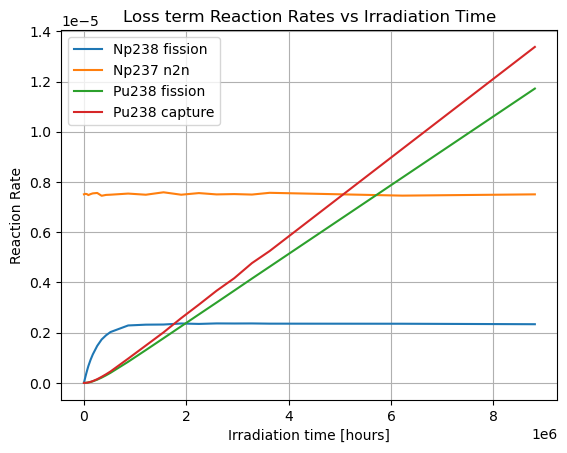

In [17]:
plt.plot(times,np238f,label='Np238 fission')
plt.plot(times,np237n2n,label='Np237 n2n');
plt.plot(times,pu238f,label='Pu238 fission')
plt.plot(times,pu238c, label='Pu238 capture')
plt.grid()
plt.legend()
plt.xlabel('Irradiation time [hours]')
plt.ylabel('Reaction Rate')
plt.title('Loss term Reaction Rates vs Irradiation Time');